In [9]:
import gensim
import os
import re
import numpy as np
import json as js
import argparse
import pandas as pd
import sklearn
import joblib
import torch
import matplotlib.pyplot as plt
import datasets
from tqdm import tqdm
from datasets import Dataset, DatasetDict
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from gensim.models import KeyedVectors
from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer



In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
def getDataJSON(route):
    with open(route,"r",encoding="utf-8") as f:
        result = [js.loads(jline.replace("diff","value")) for jline in f.read().splitlines()]
    return result

In [12]:
def specialTokens(text):
    text=text.strip()
    marked_text = "[CLS] " + text + " [SEP]"
    marked_text = marked_text.split()
    return marked_text

In [13]:
def tokenization(example,label):

    return tokenizer(example[label],padding=True, truncation=True, max_length=512,return_tensors="pt")

In [34]:
def utils_bert_embedding(txt, tokenizer, model):
    '''
    Word embedding with Bert (equivalent to nlp["word"]).
    :parameter
        :param txt: string 
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
    :return
        tensor sentences x words x vector (1x3x768) 
    '''
    # tokenize sentence to tokens (integers)
    idx = tokenizer.encode(txt,truncation=True,max_length=512)
    # convert to array of shape (1, num_words+2) - EOS and CLS added
    idx = np.array(idx)[None,:]
    # generate embeddings for each token - output is a tuple
    embedding = model(idx)
    # select first member of the tuple, remove first dimension which is 1 to get (num_words,embedding size 712)
    # exclude CLS and EOS tokens
    X = np.array(embedding[0][0][1:-1])
    return X

In [35]:
def tokenizeDataset(dataset,label):
    dataset = dataset.map(tokenization ,fn_kwargs={"label": label})
    dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "id"])
    return dataset

In [36]:
def bertMapping(inputs):
    output = model(**inputs)
    embedding = output.last_hidden_state[:,0,:]
    embedding_dict = {"exit_embedding": + embedding}
    return embedding_dict

In [37]:

def BERTProcessing(datadir,tokenizer,model):
    aux = os.path.join(datadir, "train.jsonl")
    data = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data[['text1','text2']] = pd.DataFrame(data.pair.tolist(), index= data.index)

    aux = os.path.join(datadir, "train_truth.jsonl")

    del data["pair"]
    data2 = pd.DataFrame(getDataJSON(aux)).set_index("id")
    data = pd.merge(data,data2,how='outer',left_index=True,right_index=True)
    del data2

    
    X_0 = data["text1"]
    X_0 = X_0.apply(specialTokens)
    X_0_frame=X_0.to_frame()
    lst_mean_vecs_X_0 = [utils_bert_embedding(txt,tokenizer, model).mean(0) for txt in tqdm(X_0_frame["text1"])]

    X_1 = data["text2"]
    X_1 = X_1.apply(specialTokens)
    X_1_frame=X_1.to_frame()
    lst_mean_vecs_X_1 = [utils_bert_embedding(txt,tokenizer, model).mean(0) for txt in tqdm(X_1_frame["text2"])]

    list_X_0 = X = np.array(lst_mean_vecs_X_0)
    list_X_1 = X = np.array(lst_mean_vecs_X_1)

    X=np.abs(list_X_0 - list_X_1)

    Y = data["value"].to_frame()

    X_df=pd.DataFrame(X,index=data.index)
    
    
 
    Y = data["value"]
    print("$$$$$$-DONE-$$$$$$")
    return X_df,Y



In [38]:
data=BERTProcessing("../corpus/dataset1/train/prepared/",tokenizer,model)
data


$$$$$$-DONE-$$$$$$


(              0         1         2         3         4         5         6    \
 id                                                                              
 1-1-2    0.054602  0.029144  0.285578  0.027966  0.136973  0.127164  0.172493   
 1-2-3    0.191933  0.208114  0.201736  0.124208  0.187430  0.072604  0.226926   
 10-1-2   0.106526  0.181592  0.090697  0.099095  0.015395  0.184627  0.480836   
 10-2-3   0.172492  0.001662  0.056728  0.362445  0.142959  0.447794  0.308042   
 10-3-4   0.039403  0.136093  0.256235  0.262771  0.165401  0.331002  0.015213   
 ...           ...       ...       ...       ...       ...       ...       ...   
 997-3-4  0.044000  0.067241  0.205240  0.234931  0.257679  0.220904  0.073763   
 998-1-2  0.130597  0.241268  0.277192  0.173502  0.089554  0.192770  0.280677   
 998-2-3  0.300804  0.239590  0.039977  0.110979  0.058672  0.284172  0.206494   
 999-1-2  0.115880  0.215482  0.108217  0.078844  0.202937  0.001101  0.324004   
 999-2-3  0.1009

In [41]:
data[0]

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
id,,,,,,,,,,,,,,,,,,,,,
1-1-2,0.054602,0.029144,0.285578,0.027966,0.136973,0.127164,0.172493,0.144889,0.274198,0.020211,...,0.215498,0.120135,0.267997,0.126115,0.209040,0.231648,0.103027,0.264951,0.007109,0.247231
1-2-3,0.191933,0.208114,0.201736,0.124208,0.187430,0.072604,0.226926,0.308844,0.013753,0.136113,...,0.245041,0.330320,0.123333,0.124278,0.198131,0.313089,0.172180,0.146239,0.115511,0.376772
10-1-2,0.106526,0.181592,0.090697,0.099095,0.015395,0.184627,0.480836,0.390024,0.140824,0.344884,...,0.169301,0.112428,0.278191,0.080953,0.256904,0.195504,0.339858,0.100860,0.228990,0.059523
10-2-3,0.172492,0.001662,0.056728,0.362445,0.142959,0.447794,0.308042,0.132000,0.249313,0.127021,...,0.214187,0.062333,0.326369,0.246736,0.223577,0.325203,0.225038,0.246271,0.249407,0.093771
10-3-4,0.039403,0.136093,0.256235,0.262771,0.165401,0.331002,0.015213,0.263722,0.339916,0.212217,...,0.156441,0.059327,0.081885,0.096878,0.142740,0.226771,0.049095,0.117902,0.425170,0.194695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997-3-4,0.044000,0.067241,0.205240,0.234931,0.257679,0.220904,0.073763,0.125180,0.206773,0.178157,...,0.191146,0.008283,0.050490,0.134457,0.308621,0.138664,0.042153,0.077792,0.169321,0.135871
998-1-2,0.130597,0.241268,0.277192,0.173502,0.089554,0.192770,0.280677,0.298903,0.152116,0.005054,...,0.150557,0.187793,0.049087,0.294344,0.233074,0.022200,0.134878,0.058759,0.107606,0.090147
998-2-3,0.300804,0.239590,0.039977,0.110979,0.058672,0.284172,0.206494,0.014869,0.093540,0.059234,...,0.109599,0.051158,0.024391,0.092171,0.005004,0.075547,0.021671,0.024327,0.041973,0.035361


In [43]:
def row_to_vector(row):
    return row.values

X_vectors=data[0].apply(row_to_vector,axis=1)
X_vectors

id
1-1-2      [0.05460192, 0.029143605, 0.28557754, 0.027966...
1-2-3      [0.19193277, 0.20811443, 0.20173591, 0.1242083...
10-1-2     [0.10652581, 0.18159188, 0.090696946, 0.099095...
10-2-3     [0.17249237, 0.0016616881, 0.05672817, 0.36244...
10-3-4     [0.039402768, 0.13609335, 0.256235, 0.26277074...
                                 ...                        
997-3-4    [0.044000164, 0.06724119, 0.2052402, 0.2349313...
998-1-2    [0.13059655, 0.24126819, 0.27719173, 0.1735017...
998-2-3    [0.30080354, 0.23959014, 0.039976627, 0.110979...
999-1-2    [0.11588018, 0.21548232, 0.10821736, 0.0788443...
999-2-3    [0.100991234, 0.030500015, 0.09733714, 0.06970...
Length: 12904, dtype: object

In [54]:

def plot_points_with_labels(vectors_df, labels_df):
  # Asegúrate de que las etiquetas y los vectores tengan el mismo índice
    labels_df.to_frame()
  # Separa los vectores según las etiquetas
    vectors_label_0 = vectors_df[labels_df == 0]
    vectors_label_1 = vectors_df[labels_df == 1]
    
  # Crea un gráfico de puntos
    plt.figure(figsize=(8, 6))
    plt.scatter(vectors_label_1.iloc[:, 0], vectors_label_1.iloc[:, 1], color='red', label='Con cambio')
    plt.scatter(vectors_label_0.iloc[:, 0], vectors_label_0.iloc[:, 1], color='blue', label='Sin cambio')
    
    
  # Configura las etiquetas y el título
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Embeddings Isomap')
   
  # Muestra la leyenda
    plt.legend()
   
  # Muestra el gráfico
    plt.show()

In [48]:
def redimensionarPCA(X):
    pca = PCA(n_components=2)
    X_vectores = X.apply(pd.Series)
    pca.fit(X_vectores.T)
    X_PCAvec = pd.DataFrame(pca.components_.T,index=X_vectores.index)
    return X_PCAvec


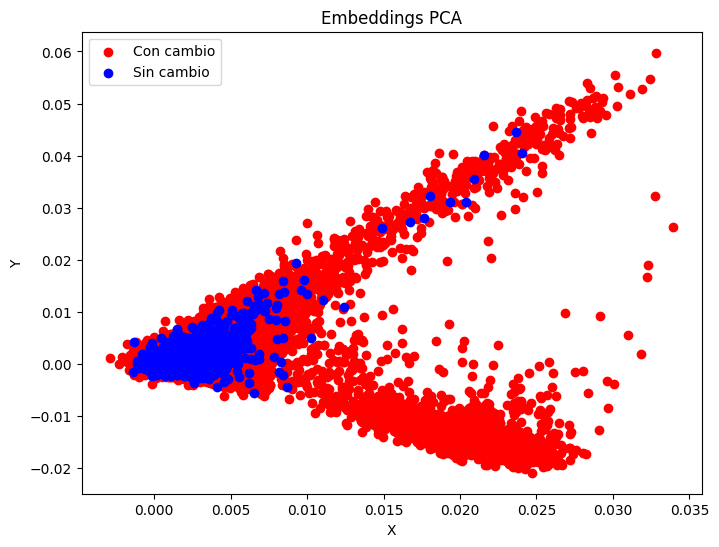

In [49]:
X_1=redimensionarPCA(X_vectors)
plot_points_with_labels(X_1,data[1])

In [50]:
def redimensionarTSNE(X):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
    X_vectores = X.apply(pd.Series)
    X_vec = tsne.fit_transform(X_vectores)
    X_TSNEvec = pd.DataFrame(X_vec,index=X_vectores.index)
    print(X_TSNEvec)
    return X_TSNEvec

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12904 samples in 0.013s...
[t-SNE] Computed neighbors for 12904 samples in 1.190s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12904
[t-SNE] Computed conditional probabilities for sample 2000 / 12904
[t-SNE] Computed conditional probabilities for sample 3000 / 12904
[t-SNE] Computed conditional probabilities for sample 4000 / 12904
[t-SNE] Computed conditional probabilities for sample 5000 / 12904
[t-SNE] Computed conditional probabilities for sample 6000 / 12904
[t-SNE] Computed conditional probabilities for sample 7000 / 12904
[t-SNE] Computed conditional probabilities for sample 8000 / 12904
[t-SNE] Computed conditional probabilities for sample 9000 / 12904
[t-SNE] Computed conditional probabilities for sample 10000 / 12904
[t-SNE] Computed conditional probabilities for sample 11000 / 12904
[t-SNE] Computed conditional probabilities for sample 12000 / 12904
[t-SNE] Computed conditional probabilities for sa

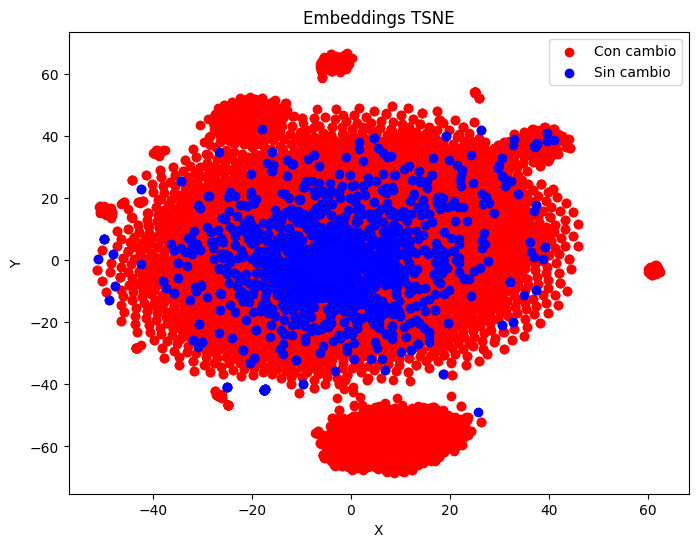

In [53]:
X_2=redimensionarTSNE(X_vectors)
plot_points_with_labels(X_2,data[1])

In [55]:
def redimensionarISOMAP(X):
    isomap=Isomap(n_components=2)
    X_vectores = X.apply(pd.Series)
    X_vec = isomap.fit_transform(X_vectores)
    X_ISOMAPvec = pd.DataFrame(X_vec,index=X_vectores.index)
    print(X_ISOMAPvec)
    return X_ISOMAPvec

/home/gianni/Documentos/DamianW2V/Transformers/env1/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 3 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/gianni/Documentos/DamianW2V/Transformers/env1/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/gianni/Documentos/DamianW2V/Transformers/env1/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/gianni/Documentos/DamianW2V/Transformers/env1/lib/python3.10/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing

                 0          1
id                           
1-1-2    -2.533040  -0.679123
1-2-3    -2.574272  -0.979347
10-1-2   20.030735  -1.786905
10-2-3   19.620466  -0.814309
10-3-4   -0.992340  -0.382703
...            ...        ...
997-3-4  -2.708456  -2.320991
998-1-2  -2.725143   2.904208
998-2-3  -2.394639  -0.479451
999-1-2  -4.787483 -11.066606
999-2-3  -1.819892  -2.029291

[12904 rows x 2 columns]


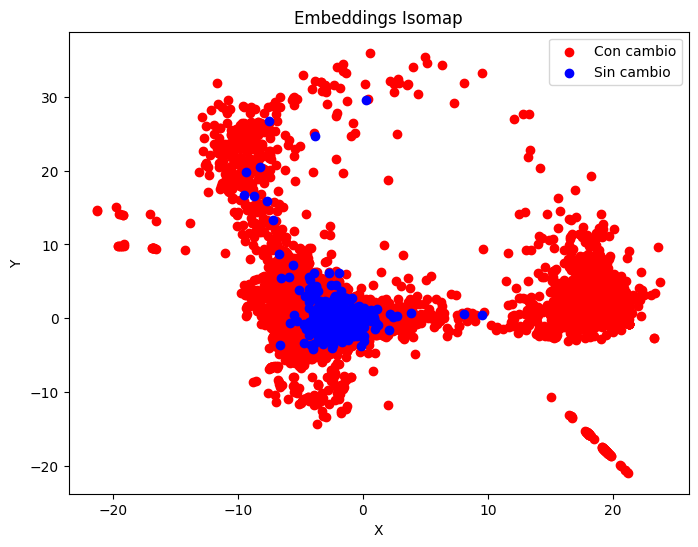

In [56]:
X_3=redimensionarISOMAP(X_vectors)
plot_points_with_labels(X_3,data[1])

In [57]:
def SVM(X,Y,exitmodel):
  print('%%%%%%TRAINING MODEL%%%%%%')
  X_train=np.array(X.tolist())
  Y_train=np.array(Y.tolist())
  svm_model = SVC(kernel='rbf')
  svm_model.fit(X_train, Y_train)
  joblib.dump(svm_model,exitmodel)

In [59]:
SVM(X_vectors,data[1],"./model/SVM_model_rbf.pkl")

%%%%%%TRAINING MODEL%%%%%%


In [60]:
def load_modelSVM(model_path):
  svm_model = joblib.load(model_path)
  return svm_model

In [61]:
def prepare_test_data(datavalidationdirectory):
  data_parsed = []

  for element in [x for x in os.listdir(datavalidationdirectory) if '.txt' in x]:
    id = re.findall(r'^[a-zA-Z\-0-9]*\-([0-9]+).txt$',element)[0]
    with open(os.path.join(datavalidationdirectory,f'problem-{id}.txt'),'r', encoding="utf-8") as f:
      data = f.readlines()

  
    comb = []
    for i in range(0,len(data)-1):
      comb.append({"id":f'{id}-{i+1}-{i+2}',"pair": [data[i],data[i+1]]})
    data_parsed.append(comb)

  with open(os.path.join(datavalidationdirectory,'validation.json'),'w',encoding="utf-8") as f:
    js.dump(data_parsed, f, indent=4)

  print("validation data prepared")


In [67]:
def evaluate_model(datavalidation_path,prediction_path,modelSVM):

  with open(os.path.join(datavalidation_path,'validation.json')) as f:
    data = js.load(f)
  print("----------- PREDICTION ------------")
  for dict in data:
    conf = []
    for dict_line in dict:
      X_0 = np.array(utils_bert_embedding(specialTokens(dict_line["pair"][0]),tokenizer, model).mean(0) )
      X_1 = np.array(utils_bert_embedding(specialTokens(dict_line["pair"][1]),tokenizer, model).mean(0) )
      X = X_0 - X_1
      X = np.absolute(X)
      X = X.reshape(1, -1)
      temp = modelSVM.predict(X)
      print(temp)
      conf.append(int(temp))

      problem_number = int(re.findall(r'([0-9]+)-[0-9]+-[0-9]+',dict_line["id"])[0])
      print(os.path.join(prediction_path,f"solution-problem-{problem_number}.json"))
      with open(os.path.join(prediction_path,f"solution-problem-{problem_number}.json"),"w+") as f:
        js.dump({"changes":conf},f)

In [68]:
modeloSVM=load_modelSVM("./model/SVM_model_rbf.pkl")

In [69]:
prepare_test_data("../corpus/dataset1/validation/")

validation data prepared


In [70]:
evaluate_model("../corpus/dataset1/validation/","../corpus/dataset1/predictionsBERTSVM/",modeloSVM)

----------- PREDICTION ------------
[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-796.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-796.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-728.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-728.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-728.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-728.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-426.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-426.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-426.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-426.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-490.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-490.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-490.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-490.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-554.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-554.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-554.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-554.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-554.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-554.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-733.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-77.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-77.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-77.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-49.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-49.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-49.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-49.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-49.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-49.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-133.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-133.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-133.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-133.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-133.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-133.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-9.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-9.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-9.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-9.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-9.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-9.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-9.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-746.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-746.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-746.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-495.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-495.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-495.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-495.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-760.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-760.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-760.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-760.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-760.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-509.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-509.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-33.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-33.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-33.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-790.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-790.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-790.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-790.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-790.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-154.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-797.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-797.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-797.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-797.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-93.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-93.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-93.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-93.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-93.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-383.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-383.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-383.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-383.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-383.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-693.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-693.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-693.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-638.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-638.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-638.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-788.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-788.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-788.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-788.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-279.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-279.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-279.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-279.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-279.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-279.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-279.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-279.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-541.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-541.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-541.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-743.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-743.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-743.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-743.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-470.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-513.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-513.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-513.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-513.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-513.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-513.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-513.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-338.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-338.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-338.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-338.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-259.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-259.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-259.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-259.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-259.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-21.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-21.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-280.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-280.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-280.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-280.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-100.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-100.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-100.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-100.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-100.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-900.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-900.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-122.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-122.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-122.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-122.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-709.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-709.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-709.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-404.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-404.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-404.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-322.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-322.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-116.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-116.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-180.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-180.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-403.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-403.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-68.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-68.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-68.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-68.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-68.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-68.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-718.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-718.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-837.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-576.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-576.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-332.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-332.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-332.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-332.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-434.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-845.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-845.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-845.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-656.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-656.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-656.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-511.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-567.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-567.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-821.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-821.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-821.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-821.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-834.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-834.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-834.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-834.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-834.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-834.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-753.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-753.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-753.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-753.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-753.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-646.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-646.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-646.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-646.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-646.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-53.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-89.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-89.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-89.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-819.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-819.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-819.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-819.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-115.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-115.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-115.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-849.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-849.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-514.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-514.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-514.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-514.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-469.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-673.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-863.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-863.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-863.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-887.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-887.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-887.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-887.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-736.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-362.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-362.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-662.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-662.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-662.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-543.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-543.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-543.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-195.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-294.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-482.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-482.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-482.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-482.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-862.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-862.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-645.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-645.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-239.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-239.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-239.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-203.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-203.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-769.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-769.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-422.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-422.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-140.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-140.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-441.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-441.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-441.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-441.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-799.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-799.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-799.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-799.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-799.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-630.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-630.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-480.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-480.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-579.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-473.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-473.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-473.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-770.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-770.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-756.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-756.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-756.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-8.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-8.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-8.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-515.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-515.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-515.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-515.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-414.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-414.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-414.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-414.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-414.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-27.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-27.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-27.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-299.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-299.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-266.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-266.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-618.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-618.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-286.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-286.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-286.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-326.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-326.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-326.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-710.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-710.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-710.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-710.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-81.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-81.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-71.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-804.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-804.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-804.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-500.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-500.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-500.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-500.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-500.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-500.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-211.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-211.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-211.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-623.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-623.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-623.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-344.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-344.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-894.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-894.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-768.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-768.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-768.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-768.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-768.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-314.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-314.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-314.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-314.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-276.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-276.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-224.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-224.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-224.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-224.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-696.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-528.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-528.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-528.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-828.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-828.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-828.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-828.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-828.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-34.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-34.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-75.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-75.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-75.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-267.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-267.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-361.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-26.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-39.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-767.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-767.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-41.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-41.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-446.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-446.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-446.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-811.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-811.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-811.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-811.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-504.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-504.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-504.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-504.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-523.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-523.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-523.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-523.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-194.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-194.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-302.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-864.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-864.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-390.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-390.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-390.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-390.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-738.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-738.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-186.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-526.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-526.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-526.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-73.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-467.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-467.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-467.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-467.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-573.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-573.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-573.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-538.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-538.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-655.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-655.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-477.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-477.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-477.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-477.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-823.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-823.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-823.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-823.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-537.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-537.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-708.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-708.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-708.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-708.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-708.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-493.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-264.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-330.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-330.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-330.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-330.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-62.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-62.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-62.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-62.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-166.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-166.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-166.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-166.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-166.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-166.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-166.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-166.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-777.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-395.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-395.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-395.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-395.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-897.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-897.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-897.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-300.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-300.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-300.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-300.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-300.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-300.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-601.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-601.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-601.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-601.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-443.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-443.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-443.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-681.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-681.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-681.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-681.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-333.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-333.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-333.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-333.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-754.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-754.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-754.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-754.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-754.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-754.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-850.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-850.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-850.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-850.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-356.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-356.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-386.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-386.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-386.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-634.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-628.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-628.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-107.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-107.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-107.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-107.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-107.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-337.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-337.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-337.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-833.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-833.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-833.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-833.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-6.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-6.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-6.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-6.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-40.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-40.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-40.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-40.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-448.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-408.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-331.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-331.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-222.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-844.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-666.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-301.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-301.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-301.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-517.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-517.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-517.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-517.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-517.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-517.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-851.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-851.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-851.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-851.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-851.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-671.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-842.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-415.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-415.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-415.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-415.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-415.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-415.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-506.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-506.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-880.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-880.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-880.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-855.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-855.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-855.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-360.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-360.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-360.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-360.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-360.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-711.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-711.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-531.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-531.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-531.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-172.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-172.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-88.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-88.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-88.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-88.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-88.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-695.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-695.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-695.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-695.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-247.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-247.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-720.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-720.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-720.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-78.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-78.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-78.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-289.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-272.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-272.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-272.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-272.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-388.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-388.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-198.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-825.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-303.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-303.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-617.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-839.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-839.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-839.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-250.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-250.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-252.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-252.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-252.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-476.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-476.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-476.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-200.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-200.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-200.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-200.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-215.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-215.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-215.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-351.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-351.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-351.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-619.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-364.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-364.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-650.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-650.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-650.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-650.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-650.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-650.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-650.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-650.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-254.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-254.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-254.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-254.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-501.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-501.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-501.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-160.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-160.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-160.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-160.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-20.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-20.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-20.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-20.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-881.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-881.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-881.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-369.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-369.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-369.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-857.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-857.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-857.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-857.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-375.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-375.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-888.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-888.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-888.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-559.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-559.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-877.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-877.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-260.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-260.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-847.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-847.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-847.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-847.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-781.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-781.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-781.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-781.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-625.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-625.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-625.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-625.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-625.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-779.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-779.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-149.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-462.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-462.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-296.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-296.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-296.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-296.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-95.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-95.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-95.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-95.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-95.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-95.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-853.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-853.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-132.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-411.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-612.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-612.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-612.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-612.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-895.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-895.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-895.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-895.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-384.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-384.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-679.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-679.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-679.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-679.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-518.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-518.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-518.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-518.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-518.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-741.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-741.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-566.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-566.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-566.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-566.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-206.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-206.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-334.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-334.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-334.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-676.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-676.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-686.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-686.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-686.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-869.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-869.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-869.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-869.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-818.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-76.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-76.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-257.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-257.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-257.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-827.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-827.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-827.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-827.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-732.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-732.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-732.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-560.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-691.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-558.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-558.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-558.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-626.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-626.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-11.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-11.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-11.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-11.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-11.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-204.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-440.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-440.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-440.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-412.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-745.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-745.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-745.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-58.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-58.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-58.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-251.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-251.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-251.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-251.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-315.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-315.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-315.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-325.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-325.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-870.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-870.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-870.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-870.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-870.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-305.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-633.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-633.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-633.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-653.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-653.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-653.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-653.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-295.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-295.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-295.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-295.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-682.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-682.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-682.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-682.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-682.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-682.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-682.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-357.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-357.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-357.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-357.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-129.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-129.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-129.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-309.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-161.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-161.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-161.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-161.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-161.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-826.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-826.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-826.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-826.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-826.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-394.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-588.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-588.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-588.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-636.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-636.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-636.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-118.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-118.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-613.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-613.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-613.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-613.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-648.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-648.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-648.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-805.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-879.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-879.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-879.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-347.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-347.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-672.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-672.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-672.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-672.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-400.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-400.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-400.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-400.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-400.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-400.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-400.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-400.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-572.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-572.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-572.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-587.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-587.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-561.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-561.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-669.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-669.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-669.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-150.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-150.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-150.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-150.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-150.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-555.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-555.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-555.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-555.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-555.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-555.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-170.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-170.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-170.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-436.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-436.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-293.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-293.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-293.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-293.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-293.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-585.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-585.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-585.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-519.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-519.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-519.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-519.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-519.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-725.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-725.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-791.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-791.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-791.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-460.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-460.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-460.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-51.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-51.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-51.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-51.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-51.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-51.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-380.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-380.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-872.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-872.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-872.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-846.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-846.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-846.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-846.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-846.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-846.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-846.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-48.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-48.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-540.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-540.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-540.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-540.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-540.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-632.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-632.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-632.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-632.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-843.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-843.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-843.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-843.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-105.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-875.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-875.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-875.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-875.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-177.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-177.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-683.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-683.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-683.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-683.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-683.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-569.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-569.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-592.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-592.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-773.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-773.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-773.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-597.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-597.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-492.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-492.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-492.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-492.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-780.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-780.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-876.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-876.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-876.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-876.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-876.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-164.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-164.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-871.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-871.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-871.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-871.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-109.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-109.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-109.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-109.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-508.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-508.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-816.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-437.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-437.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-437.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-615.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-615.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-548.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-70.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-70.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-817.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-817.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-817.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-817.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-639.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-639.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-639.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-550.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-550.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-550.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-83.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-83.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-83.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-810.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-810.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-396.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-221.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-221.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-221.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-757.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-757.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-757.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-757.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-658.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-658.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-658.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-658.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-117.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-117.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-117.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-117.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-602.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-602.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-148.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-341.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-341.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-341.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-43.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-43.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-43.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-789.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-789.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-789.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-789.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-392.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-392.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-392.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-454.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-454.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-389.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-389.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-389.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-389.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-700.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-700.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-700.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-698.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-698.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-381.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-381.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-381.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-181.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-181.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-181.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-137.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-137.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-137.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-137.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-137.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-137.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-428.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-428.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-428.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-228.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-228.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-228.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-228.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-128.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-128.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-525.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-525.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-525.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-318.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-583.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-749.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-749.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-627.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-627.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-627.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-468.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-468.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-468.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-468.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-521.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-521.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-521.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-521.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-171.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-171.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-171.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-171.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-261.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-261.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-776.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-776.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-776.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-776.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-114.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-114.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-114.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-393.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-393.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-393.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-393.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-393.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-832.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-832.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-832.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-578.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-578.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-578.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-420.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-420.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-420.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-420.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-471.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-478.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-478.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-478.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-201.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-201.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-201.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-201.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-678.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-678.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-678.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-591.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-591.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-591.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-591.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-591.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-774.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-499.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-499.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-499.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-499.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-24.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-24.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-24.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-24.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-735.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-735.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-735.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-735.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-735.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-274.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-274.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-835.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-835.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-835.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-835.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-835.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-835.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-185.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-185.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-185.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-185.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-185.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-282.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-282.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-232.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-232.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-232.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-474.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-474.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-47.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-47.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-487.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-487.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-487.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-584.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-584.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-584.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-584.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-584.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-152.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-152.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-748.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-168.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-729.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-729.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-729.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-729.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-859.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-859.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-859.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-859.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-809.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-809.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-809.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-809.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-126.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-126.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-126.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-126.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-798.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-798.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-798.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-798.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-798.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-840.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-840.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-724.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-724.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-724.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-624.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-153.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-153.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-153.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-121.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-121.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-121.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-121.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-405.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-405.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-405.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-258.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-258.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-258.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-258.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-258.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-306.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-306.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-306.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-306.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-742.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-742.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-348.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-891.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-891.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-891.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-891.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-253.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-253.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-253.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-253.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-447.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-447.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-447.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-447.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-99.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-563.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-563.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-563.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-563.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-668.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-668.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-668.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-668.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-233.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-233.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-233.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-233.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-233.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-275.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-275.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-275.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-275.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-10.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-10.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-63.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-63.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-63.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-30.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-30.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-30.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-30.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-30.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-486.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-486.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-486.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-486.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-245.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-245.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-245.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-874.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-234.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-234.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-234.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-234.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-179.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-179.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-179.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-179.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-831.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-831.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-831.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-235.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-235.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-235.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-802.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-802.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-802.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-802.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-494.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-494.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-494.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-110.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-110.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-110.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-510.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-510.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-510.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-510.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-510.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-46.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-46.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-46.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-46.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-46.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-737.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-737.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-737.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-737.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-737.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-479.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-479.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-479.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-479.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-56.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-56.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-56.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-277.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-277.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-277.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-439.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-439.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-439.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-439.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-14.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-14.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-14.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-14.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-4.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-4.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-4.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-174.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-174.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-174.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-174.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-174.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-387.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-387.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-455.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-455.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-455.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-687.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-687.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-142.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-142.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-142.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-142.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-142.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-765.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-765.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-765.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-765.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-178.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-178.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-178.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-740.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-740.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-740.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-740.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-368.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-368.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-368.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-609.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-609.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-609.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-771.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-771.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-771.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-892.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-892.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-130.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-130.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-130.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-223.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-223.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-223.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-223.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-223.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-223.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-213.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-28.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-28.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-28.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-28.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-28.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-52.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-52.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-52.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-65.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-65.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-65.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-730.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-433.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-433.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-433.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-705.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-705.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-705.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-339.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-339.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-339.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-339.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-758.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-758.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-352.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-450.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-450.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-759.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-759.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-759.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-489.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-489.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-489.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-489.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-660.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-660.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-660.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-660.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-660.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-273.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-273.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-273.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-896.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-896.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-432.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-432.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-82.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-82.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-82.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-883.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-883.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-883.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-883.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-883.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-155.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-155.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-155.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-155.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-155.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-582.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-582.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-582.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-582.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-124.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-124.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-124.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-124.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-124.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-371.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-637.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-637.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-637.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-637.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-761.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-761.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-761.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-429.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-429.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-429.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-429.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-429.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-429.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-713.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-713.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-409.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-409.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-64.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-64.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-64.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-64.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-262.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-262.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-890.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-890.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-147.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-147.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-320.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-292.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-292.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-292.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-701.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-701.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-701.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-701.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-701.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-151.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-151.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-54.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-54.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-54.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-463.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-463.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-419.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-419.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-419.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-355.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-355.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-328.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-328.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-670.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-670.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-670.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-670.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-410.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-410.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-410.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-410.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-657.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-657.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-657.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-520.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-520.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-520.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-445.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-445.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-205.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-205.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-704.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-704.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-739.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-739.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-739.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-752.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-752.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-752.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-752.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-502.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-702.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-702.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-702.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-481.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-812.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-812.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-812.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-801.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-801.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-801.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-786.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-786.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-786.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-483.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-483.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-496.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-496.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-496.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-545.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-545.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-545.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-316.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-316.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-614.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-614.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-442.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-442.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-442.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-442.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-442.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-442.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-568.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-340.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-340.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-340.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-466.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-466.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-92.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-694.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-694.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-13.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-13.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-13.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-158.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-158.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-158.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-684.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-427.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-427.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-813.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-813.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-813.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-813.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-85.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-85.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-336.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-336.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-689.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-689.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-808.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-808.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-808.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-808.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-522.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-522.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-522.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-547.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-547.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-547.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-547.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-90.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-90.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-191.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-191.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-782.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-782.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-782.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-782.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-782.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-782.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-782.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-782.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-193.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-193.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-193.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-193.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-193.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-193.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-193.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-86.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-86.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-86.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-86.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-240.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-240.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-240.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-622.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-217.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-217.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-217.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-217.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-652.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-652.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-652.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-652.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-652.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-358.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-358.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-690.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-690.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-196.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-196.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-196.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-219.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-219.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-219.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-219.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-385.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-385.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-385.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-113.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-586.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-586.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-586.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-586.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-350.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-350.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-350.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-350.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-350.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-575.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-575.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-575.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-530.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-530.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-391.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-391.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-391.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-464.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-464.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-464.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-2.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-2.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-2.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-2.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-22.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-22.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-365.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-365.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-365.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-635.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-285.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-285.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-285.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-324.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-324.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-599.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-599.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-599.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-688.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-688.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-688.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-688.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-866.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-866.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-747.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-747.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-747.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-747.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-425.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-425.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-425.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-425.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-425.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-425.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-425.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-542.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-542.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-542.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-542.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-553.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-722.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-722.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-722.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-144.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-144.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-524.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-524.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-524.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-524.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-574.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-574.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-574.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-574.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-574.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-220.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-220.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-220.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-643.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-643.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-629.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-629.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-692.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-692.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-459.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-459.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-546.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-546.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-893.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-893.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-893.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-893.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-465.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-465.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-556.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-556.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-556.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-556.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-556.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-841.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-841.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-268.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-268.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-268.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-707.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-707.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-141.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-557.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-557.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-557.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-557.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-557.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-557.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-795.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-795.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-795.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-795.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-795.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-795.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-32.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-32.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-32.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-32.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-32.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-32.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-32.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-606.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-606.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-604.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-604.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-604.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-604.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-156.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-667.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-667.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-667.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-706.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-706.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-706.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-69.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-284.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-284.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-284.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-284.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-284.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-438.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-438.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-192.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-192.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-192.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-131.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-131.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-535.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-535.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-535.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-417.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-417.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-417.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-183.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-183.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-183.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-287.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-287.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-287.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-287.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-287.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-886.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-886.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-886.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-886.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-886.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-886.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-886.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-886.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-398.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-398.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-398.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-398.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-61.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-61.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-61.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-867.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-867.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-867.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-867.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-815.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-815.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-815.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-562.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-562.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-562.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-838.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-838.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-838.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-838.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-42.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-42.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-42.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-42.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-378.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-378.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-378.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-611.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-611.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-346.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-346.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-346.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-346.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-346.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-533.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-533.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-533.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-16.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-516.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-516.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-165.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-165.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-165.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-165.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-570.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-716.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-716.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-716.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-401.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-401.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-401.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-401.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-644.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-644.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-644.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-644.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-552.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-552.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-552.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-552.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-98.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-98.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-98.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-18.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-238.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-238.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-374.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-374.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-45.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-45.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-45.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-45.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-45.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-430.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-430.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-430.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-430.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-304.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-304.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-304.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-304.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-858.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-858.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-858.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-775.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-775.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-775.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-775.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-703.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-703.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-703.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-703.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-60.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-60.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-60.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-60.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-298.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-298.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-298.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-298.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-714.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-714.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-714.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-55.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-3.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-3.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-17.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-17.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-17.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-189.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-189.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-189.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-189.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-184.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-184.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-184.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-680.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-680.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-680.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-680.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-680.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-854.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-854.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-854.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-104.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-104.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-104.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-291.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-291.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-291.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-135.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-135.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-135.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-719.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-719.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-255.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-207.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-207.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-207.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-207.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-491.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-491.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-491.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-491.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-491.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-488.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-488.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-488.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-488.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-377.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-377.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-377.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-87.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-87.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-87.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-87.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-87.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-372.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-372.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-372.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-372.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-372.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-461.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-532.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-596.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-596.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-596.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-596.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-457.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-457.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-734.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-734.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-734.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-734.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-297.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-297.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-297.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-297.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-297.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-297.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-565.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-731.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-731.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-731.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-731.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-731.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-717.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-717.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-25.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-25.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-898.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-898.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-898.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-898.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-539.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-539.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-539.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-539.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-631.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-631.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-5.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-600.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-600.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-600.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-12.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-12.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-12.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-12.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-74.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-74.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-74.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-74.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-74.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-581.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-581.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-581.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-581.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-751.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-376.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-376.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-376.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-376.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-376.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-764.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-764.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-764.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-366.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-366.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-366.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-366.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-794.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-209.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-209.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-209.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-209.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-379.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-379.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-379.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-103.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-103.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-103.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-319.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-319.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-138.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-138.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-677.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-677.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-677.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-677.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-868.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-119.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-119.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-119.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-119.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-119.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-263.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-263.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-721.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-67.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-67.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-67.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-67.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-241.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-241.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-241.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-197.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-197.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-197.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-197.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-197.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-822.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-246.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-246.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-120.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-281.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-281.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-281.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-281.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-281.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-664.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-226.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-226.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-616.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-616.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-616.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-616.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-616.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-485.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-485.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-249.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-249.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-29.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-29.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-29.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-674.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-674.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-674.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-674.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-674.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-784.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-784.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-784.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-167.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-167.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-167.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-167.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-820.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-820.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-820.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-820.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-820.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-598.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-598.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-349.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-349.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-382.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-382.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-31.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-31.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-101.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-101.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-101.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-101.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-865.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-865.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-865.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-865.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-889.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-889.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-889.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-889.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-889.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-106.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-91.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-91.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-91.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-91.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-882.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-882.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-218.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-218.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-218.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-38.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-38.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-38.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-824.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-824.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-824.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-824.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-79.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-79.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-659.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-659.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-136.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-96.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-96.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-96.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-256.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-256.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-256.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-256.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-536.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-536.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-536.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-536.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-595.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-595.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-102.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-102.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-202.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-202.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-202.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-202.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-675.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-675.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-675.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-800.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-800.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-444.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-444.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-444.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-783.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-783.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-783.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-783.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-783.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-783.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-290.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-290.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-308.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-308.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-308.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-806.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-806.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-806.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-453.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-453.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-453.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-44.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-367.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-367.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-367.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-50.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-50.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-50.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-772.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-108.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-108.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-108.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-108.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-359.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-359.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-359.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-359.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-527.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-856.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-856.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-856.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-856.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-182.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-182.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-829.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-829.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-829.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-829.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-507.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-507.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-507.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-157.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-157.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-157.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-157.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-785.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-785.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-785.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-321.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-321.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-321.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-603.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-603.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-603.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-603.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-651.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-651.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-651.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-651.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-651.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-651.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-270.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-270.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-270.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-270.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-270.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-620.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-311.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-311.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-311.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-208.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-208.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-208.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-208.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-59.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-59.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-227.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-227.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-227.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-663.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-663.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-663.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-663.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-663.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-505.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-505.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-505.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-505.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-594.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-594.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-594.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-564.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-564.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-564.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-564.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-564.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-564.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-564.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-564.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-778.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-778.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-778.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-778.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-778.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-778.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-778.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-830.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-830.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-830.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-830.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-36.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-435.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-435.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-435.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-727.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-727.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-727.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-727.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-577.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-577.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-814.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-175.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-175.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-512.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-512.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-512.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-726.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-726.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-726.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-452.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-452.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-452.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-452.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-452.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-484.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-484.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-484.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-484.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-123.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-123.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-265.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-265.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-472.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-472.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-472.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-354.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-354.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-354.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-190.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-190.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-190.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-456.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-237.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-237.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-237.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-248.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-248.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-248.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-143.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-143.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-143.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-143.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-1.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-307.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-307.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-134.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-278.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-278.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-278.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-278.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-278.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-278.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-278.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-278.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-343.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-343.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-697.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-329.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-329.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-329.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-607.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-607.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-762.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-762.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-762.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-762.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-327.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-327.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-327.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-327.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-15.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-15.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-15.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-15.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-15.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-15.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-610.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-610.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-431.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-431.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-431.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-712.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-712.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-271.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-271.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-271.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-399.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-803.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-803.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-803.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-397.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-397.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-169.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-169.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-169.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-242.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-269.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-269.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-269.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-269.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-230.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-230.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-230.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-230.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-353.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-353.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-353.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-353.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-353.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-353.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-551.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-551.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-787.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-787.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-787.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-750.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-750.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-793.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-793.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-793.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-793.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-793.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-793.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-529.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-529.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-529.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-317.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-317.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-173.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-173.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-685.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-685.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-685.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-685.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-685.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-685.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-549.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-549.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-549.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-549.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-549.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-421.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-421.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-66.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-66.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-66.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-66.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-162.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-162.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-544.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-544.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-544.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-544.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-878.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-878.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-37.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-57.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-57.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-57.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-57.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-229.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-212.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-212.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-212.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-288.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-288.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-288.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-288.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-288.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-214.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-214.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-112.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-112.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-146.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-146.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-146.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-146.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-146.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-188.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-188.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-188.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-899.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-899.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-899.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-323.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-649.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-723.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-723.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-593.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-593.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-593.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-451.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-451.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-451.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-451.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-640.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-640.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-640.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-159.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-159.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-159.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-159.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-231.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-231.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-231.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-231.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-231.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-231.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-503.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-503.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-503.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-503.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-503.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-503.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-23.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-23.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-23.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-23.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-23.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-335.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-335.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-335.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-335.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-418.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-418.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-418.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-418.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-534.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-534.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-534.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-534.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-534.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-647.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-654.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-654.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-654.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-654.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-125.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-125.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-236.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-236.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-236.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-236.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-139.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-139.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-139.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-766.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-766.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-766.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-7.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-7.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-7.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-590.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-590.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-590.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-608.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-608.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-608.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-608.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-313.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-313.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-313.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-873.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-449.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-449.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-449.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-449.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-744.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-744.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-744.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-72.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-72.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-72.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-373.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-373.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-373.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-571.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-498.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-498.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-498.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-498.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-498.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-342.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-342.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-145.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-145.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-145.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-580.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-580.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-580.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-605.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-605.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-605.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-605.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-605.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-407.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-407.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-407.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-407.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-363.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-363.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-363.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-363.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-885.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-885.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-885.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-885.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-661.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-661.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-661.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-661.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-416.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-416.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-416.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-792.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-792.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-792.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-792.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-406.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-589.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-589.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-589.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-848.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-848.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-848.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-94.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-94.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-94.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-763.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-763.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-763.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-763.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-458.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-458.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-475.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-475.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-187.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-187.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-187.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-312.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-312.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-312.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-836.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-836.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-836.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-836.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-836.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-836.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-283.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-621.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-621.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-621.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-621.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-621.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-497.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-884.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-80.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-80.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-80.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-860.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-424.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-424.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-424.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-127.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-127.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-127.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-127.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-35.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-35.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-715.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-642.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-244.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-244.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-244.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-244.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-699.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-699.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-699.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-423.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-423.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-423.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-243.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-243.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-243.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-310.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-310.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-310.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-370.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-370.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-370.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-370.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-370.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-370.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-370.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[0]
../corpus/dataset1/predictionsBERTSVM/solution-problem-370.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-755.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-225.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-225.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-225.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-84.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-84.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-84.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-210.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-210.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-111.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-111.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-413.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-413.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-413.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-413.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-413.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-19.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-19.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-19.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-19.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-216.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-216.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-861.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-861.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-861.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-402.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-402.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-402.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-345.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-345.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-345.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-345.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-807.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-807.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-807.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-163.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-163.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-163.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-163.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-852.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-852.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-852.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-97.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-97.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-97.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-97.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-176.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-176.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-176.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-176.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-665.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-665.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-641.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-641.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-641.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-641.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))


[1]
../corpus/dataset1/predictionsBERTSVM/solution-problem-199.json


/tmp/ipykernel_10031/1710573279.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf.append(int(temp))
